<a href="https://colab.research.google.com/github/dweinflash/CS293B_Cloud/blob/master/experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git#egg=tensorflow-examples[model_maker]

In [ ]:
import os
import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tensorflow_examples.lite.model_maker.core.data_util.image_dataloader import ImageClassifierDataLoader
from tensorflow_examples.lite.model_maker.core.task import image_classifier
from tensorflow_examples.lite.model_maker.core.task.model_spec import efficientnet_lite0_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import efficientnet_lite1_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import efficientnet_lite2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import efficientnet_lite3_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import efficientnet_lite4_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import mobilenet_v2_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import resnet_50_spec
from tensorflow_examples.lite.model_maker.core.task.model_spec import ImageModelSpec

import matplotlib.pyplot as plt

Train a model on raw images

In [ ]:
# Images
train_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/TrainImages')
val_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/ValidationImages')
test_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/TestImages')

# Data
train_data = ImageClassifierDataLoader.from_folder(train_images)
val_data = ImageClassifierDataLoader.from_folder(val_images)
test_data = ImageClassifierDataLoader.from_folder(test_images)

# Fit
model = image_classifier.create(train_data, model_spec=efficientnet_lite4_spec, validation_data=val_data, epochs=5, dropout_rate=0.25)
loss, accuracy = model.evaluate(test_data)

# Export
model.export(export_dir='.')

Train a model on raw and augmented images

In [ ]:
# Classes
classes = ['Paper', 'Rock', 'Scissors']

# Images
train_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/TrainImages')
val_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/ValidationImages')
test_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/TestImages')

# Data
train_data_raw = ImageClassifierDataLoader.from_folder(train_images)
val_data = ImageClassifierDataLoader.from_folder(val_images)
test_data = ImageClassifierDataLoader.from_folder(test_images)

def augment(image,label):
  if (aug == 1): image = tf.image.resize_with_crop_or_pad(image, 128, 128) # Resize
  if (aug == 2): image = tf.image.random_crop(image, size=[150, 150, 3]) # Random crop
  if (aug == 3): image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  if (aug == 4): image = tf.image.central_crop(image, central_fraction=0.5) # Center crop
  if (aug == 5): image = tf.image.flip_left_right(image) # Flip
  if (aug == 6): image = tf.image.random_contrast(image, 0.2, 0.5) # Contrast

  return image,label

# Combine raw train dataset with augmented datasets
aug = 1
all_data = train_data_raw.dataset
for i in range(0,6):
  aug_data = (train_data_raw.dataset .map(augment))
  all_data = all_data.concatenate(aug_data)
  aug += 1

size = tf.data.experimental.cardinality(all_data).numpy()
train_data = ImageClassifierDataLoader(all_data, size, len(classes), classes)

model = image_classifier.create(train_data, model_spec=efficientnet_lite3_spec, validation_data=val_data, epochs=10, dropout_rate=0.25)
loss, accuracy = model.evaluate(test_data)

model.export(export_dir='.')

Train EfficientNets or ConvNets and graph training data/validation data performance

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Images
train_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/TrainImages')
val_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/ValidationImages')
test_images = os.path.abspath('drive/My Drive/Colab Notebooks/CS293B/TestImages')

# Data
train_data = ImageClassifierDataLoader.from_folder(train_images)
val_data = ImageClassifierDataLoader.from_folder(val_images)
test_data = ImageClassifierDataLoader.from_folder(test_images)

# Models
effNets = [efficientnet_lite0_spec, efficientnet_lite1_spec, efficientnet_lite2_spec, 
           efficientnet_lite3_spec, efficientnet_lite4_spec]

inception_v3_spec = ImageModelSpec(uri='https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1')
inception_v3_spec.input_image_shape = [299, 299]

convNets = [mobilenet_v2_spec, resnet_50_spec, inception_v3_spec]
convNets_name = ['mobilenet', 'resnet', 'inception_v3']

# History
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
histories = {}

# Fit
evals = []
for i in range(len(convNets)):
  model = image_classifier.create(train_data, model_spec=convNets[i], validation_data=val_data, epochs=5, dropout_rate=0.25)
  histories[convNets_name[i]] = model.history
  loss, accuracy = model.evaluate(test_data)
  evals.append([loss,accuracy])

print(evals)

# Plot
plotter.plot(histories)
ax = plt.subplot(111)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([0.3, 0.7])

Graph test set evaluations

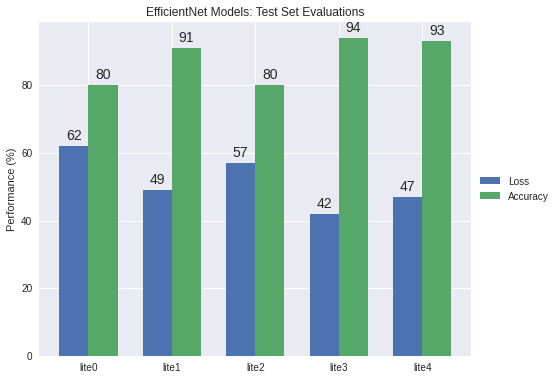

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# style
mpl.style.use('seaborn')

labels = ['lite0', 'lite1', 'lite2', 'lite3', 'lite4']
loss = [62, 49, 57, 42, 47]
acc = [80, 91, 80, 94, 93]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, loss, width, label='Loss')
rects2 = ax.bar(x + width/2, acc, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance (%)')
ax.set_title('EfficientNet Models: Test Set Evaluations')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Graph inference latency and model size for model groups

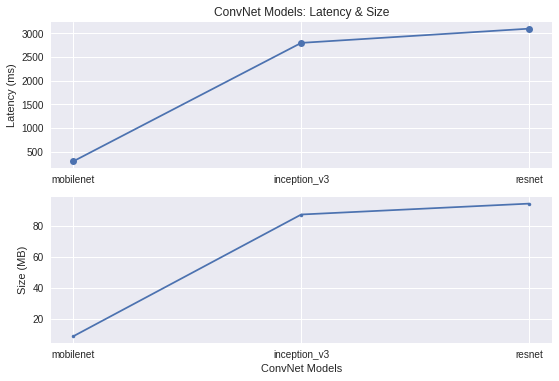

In [ ]:
labels_eff = ['lite0', 'lite1', 'lite2', 'lite3', 'lite4']
labels_conv = ['mobilenet', 'inception_v3', 'resnet']

# model types
# x1 = np.arange(len(labels_eff))
x1 = np.arange(len(labels_conv))

# latency, size
y1 = [300, 2800, 3100]
y2 = [8.9, 87.2, 94.2]

ax = plt.subplot(2, 1, 1)
ax.set_xticks(x1)
ax.set_xticklabels(labels_conv)
plt.plot(x1, y1, 'o-')
plt.title('ConvNet Models: Latency & Size')
plt.ylabel('Latency (ms)')

ax = plt.subplot(2, 1, 2)
ax.set_xticks(x1)
ax.set_xticklabels(labels_conv)
plt.plot(x1, y2, '.-')
plt.xlabel('ConvNet Models')
plt.ylabel('Size (MB)')

plt.show()